In [2]:
# Install Software and check its version
! pip install -q 'gwosc==0.5.4'
import gwosc
print(gwosc.__version__)

# #Uncomment this section to install everything once 

# ! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0' 'gwpy==2.0.2'
# ! pip install matplotlib==3.1.3
# # -- Click "restart runtime" in the runtime menu after recommenting all this

0.5.4


In [3]:
 # Import all needed librairies and methods
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab

import pycbc.types 
from pycbc.types import TimeSeries

import pycbc.noise

import pycbc.psd
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pycbc.filter
from pycbc.filter import resample_to_delta_t, highpass, matched_filter

import pycbc.waveform
from pycbc.waveform import get_td_waveform

In [4]:
### Loading Data ###
#--> from google doc sheet of assignment

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge3.gwf', channel="H1:CHALLENGE3")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')



--2022-02-14 13:31:58--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  15.6MB/s    in 16s     

2022-02-14 13:32:14 (15.6 MB/s) - ‘challenge3.gwf’ saved [256815066/256815066]



In [5]:
#solar masses for this exercise
m = 10

#approximant
apx = 'SEOBNRv4_opt'

1) What is the merger time of this signal?

In [6]:
## Just like for the previous challenge, plot the snr
#the Q-transform and spectogram would not work because of the added simulated signals
#Hence, to know which one is the right signal, do SNR


In [7]:
 #Reuse Challenge 2 for the most part to have the SNR

# Remove the low frequency content and downsample the data to 2048Hz

pycbc_strain = highpass(pycbc_strain, 15.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)

# Condition data = Remove 2 seconds of data from both the beginning and end 
conditioned_strain = pycbc_strain.crop(2,2)

#set the "plus" polarization template
hp, _ = get_td_waveform(approximant=apx,
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned_strain.delta_t,
                     f_lower=25)

# Resize the vector to match our data
hp.resize(len(conditioned_strain))

#shift the template
template = hp.cyclic_time_shift(hp.start_time)


#compute PSD and work it out
psd = conditioned_strain.psd(4)

psd = interpolate(psd, conditioned_strain.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * pycbc_strain.sample_rate),
                                  low_frequency_cutoff=15)



In [8]:
# # Let's plot the signal before and after shifting

# pylab.figure()
# pylab.title('Before shifting')
# pylab.plot(hp.sample_times, hp)
# pylab.xlabel('Time (s)')
# pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

# pylab.figure()
# pylab.title('After shifting')
# pylab.plot(template.sample_times, template)
# pylab.xlabel('Time (s)')
# pylab.ylabel('Strain')

##not needed 

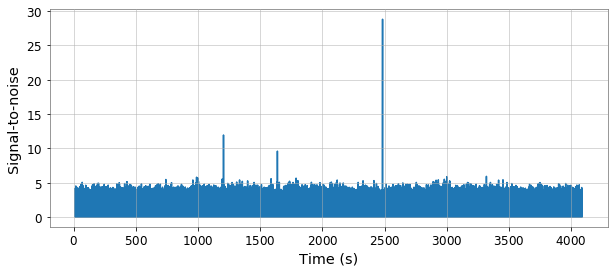

We found a signal at 2483.96728515625s with SNR 28.82874563250029


In [9]:
# Plot the SNR time-series
#(code from tutorial)
snr = matched_filter(template, 
                     conditioned_strain,
                     psd=psd, 
                     low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax() # find the peak (its location in the array)
snrp = snr[peak] # get its SNR value
time = snr.sample_times[peak] # get its location (in time)

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [10]:
#the merger is at maximum SNR. Hence, merger is at t = 2483.96728515625s

2) What is the matched-filter SNR of this signal?

In [11]:
#answered with the previous code: matched-filter SNR = 28.828814019684607